In [11]:
import numpy as np
import pandas as pd
import joblib
import json
import os
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------
# ---------- PART A ----------
# Train RUL model from uploaded Excel
# ----------------------------
def train_rul_model_from_excel(excel_path,
                               model_out_path="rul_model.pkl",
                               scaler_out_path="scaler.pkl",
                               features_json_path="features_list.json",
                               exclude_cols=('Pavg', 'iAvg')):
    """
    Trains a simple RandomForest RUL model using the columns present
    in the Excel (Freq_1..Freq_5, Peak_1..Peak_5, Int Fault, etc).
    Saves model, scaler and the feature order (json).
    """
    print("Loading dataset:", excel_path)
    df = pd.read_excel(excel_path)

    # Drop unwanted columns and unnamed artifacts
    df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors='ignore')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna(subset=['Fault'], how='any')

    # Fill numeric NaNs with median (safe fallback)
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    # Compute RUL per Fault group (as you did earlier)
    if 'Fault' not in df.columns or 'Run' not in df.columns:
        raise ValueError("Excel must contain 'Fault' and 'Run' columns for RUL labeling.")
    df['RUL'] = df.groupby('Fault')['Run'].transform(lambda x: x.max() - x)

    # Define feature columns that we'll use for modeling (explicit)
    # look for Freq_1..Freq_5 and Peak_1..Peak_5 and Int Fault if present
    feature_candidates = []
    for i in range(1, 6):
        fcol = f"Freq_{i}"
        pcol = f"Peak_{i}"
        if fcol in df.columns:
            feature_candidates.append(fcol)
        if pcol in df.columns:
            feature_candidates.append(pcol)
    if 'Int Fault' in df.columns:
        feature_candidates.append('Int Fault')

    if len(feature_candidates) == 0:
        # Fallback: use all numeric excluding Run/RUL
        feature_candidates = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ('Run','RUL')]

    print("Using features:", feature_candidates)

    X = df[feature_candidates].copy()
    y = df['RUL'].copy()

    # Train/test split (group-aware if Fault exists)
    groups = df['Fault'] if 'Fault' in df.columns else None
    if groups is not None:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
        train_idx, test_idx = next(gss.split(X, y, groups=groups))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Train RandomForest baseline
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train_s, y_train)

    # Evaluate
    preds = rf.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, preds)) # Fix: Removed 'squared=False' and added np.sqrt
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print("RUL model performance (test): RMSE={:.4f}, MAE={:.4f}, R2={:.4f}".format(rmse, mae, r2))

    # Save artifacts
    joblib.dump(rf, model_out_path)
    joblib.dump(scaler, scaler_out_path)
    with open(features_json_path, 'w') as f:
        json.dump(feature_candidates, f)

    print("Saved model to", model_out_path)
    print("Saved scaler to", scaler_out_path)
    print("Saved feature order to", features_json_path)
    return model_out_path, scaler_out_path, features_json_path

# ----------------------------
# Helper: convert raw (flow, pressure) -> sensor-like features
# (we compute top 5 spectral peaks + their frequencies)
# ----------------------------
def waveform_to_sensor_features(flow, pressure, fs=10, top_n=5, include_int_fault=0):
    """
    Given time-series flow & pressure arrays and sampling frequency fs,
    compute sensor-like features consistent with the Excel:
      - Freq_1..Freq_5: frequencies of top_n spectral peaks (Hz)
      - Peak_1..Peak_5: amplitudes of those peaks
      - Int Fault: optional integer flag (user-supplied)
    If fewer than top_n peaks found, remaining entries are filled with 0.
    Returns a dict mapping feature name -> value.
    """
    # Combine flow & pressure spectrum by averaging normalized spectral magnitudes
    N = len(flow)
    # Detrend (remove mean)
    flow_c = flow - np.mean(flow)
    pressure_c = pressure - np.mean(pressure)

    # Compute rfft (positive freqs)
    yf1 = np.abs(rfft(flow_c))
    yf2 = np.abs(rfft(pressure_c))
    freqs = rfftfreq(N, d=1.0/fs)

    # Normalize and combine
    yf1_n = yf1 / (np.max(yf1) + 1e-12)
    yf2_n = yf2 / (np.max(yf2) + 1e-12)
    comb = (yf1_n + yf2_n) / 2.0

    # Exclude DC bin (freq=0)
    comb_no_dc = comb.copy()
    comb_no_dc[0] = 0.0

    # Find peaks in the combined spectrum
    peaks_idx, _ = find_peaks(comb_no_dc, height=0.01)  # height threshold = 0.01 (tunable)
    # Sort peaks by amplitude descending
    peaks_sorted = sorted(peaks_idx, key=lambda i: comb_no_dc[i], reverse=True)

    # Prepare feature dict
    feat = {}
    for i in range(top_n):
        name_freq = f"Freq_{i+1}"
        name_peak = f"Peak_{i+1}"
        if i < len(peaks_sorted):
            idx = peaks_sorted[i]
            feat[name_freq] = float(freqs[idx])
            # Amplitude take from combined (or raw) spectrum
            feat[name_peak] = float(comb_no_dc[idx])
        else:
            feat[name_freq] = 0.0
            feat[name_peak] = 0.0

    # Additional features sometimes required: Int Fault
    feat['Int Fault'] = int(include_int_fault)

    return feat

# ----------------------------
# PART B: Digital twin integration: simulate -> extract -> predict
# We include your FluidSimulator classes (adapted) below.
# ----------------------------
import math
# Reuse your FluidSimulator code but slightly adapted to accept saved models
class FluidSimulator:
    def __init__(self, fs=10, duration=600):
        self.fs = fs
        self.duration = duration
        self.time = np.arange(duration) / fs

    def simulate_base_signals(self):
        """Default (normal) flow and pressure without faults."""
        flow = 1.2 + 0.02*np.random.randn(self.duration)
        pressure = 1.18 + 0.02*np.random.randn(self.duration)
        return flow, pressure

    def inject_faults(self, flow, pressure):
        """To be overridden by subclasses with fluid-specific fault logic."""
        return flow, pressure

    # We no longer use the older extract_features (it returned different names).
    # Instead we convert to sensor-like features via waveform_to_sensor_features()
    def run(self, inject_int_fault=0):
        flow, pressure = self.simulate_base_signals()
        flow, pressure = self.inject_faults(flow, pressure)

        # Convert waveform to sensor features (Freq_1..5, Peak_1..5, Int Fault)
        features_dict = waveform_to_sensor_features(flow, pressure, fs=self.fs, top_n=5, include_int_fault=inject_int_fault)
        return features_dict, flow, pressure

class WaterSimulator(FluidSimulator):
    def inject_faults(self, flow, pressure):
        # Example fault: leakage → lower flow, oscillating pressure
        # We'll create a leakage region in the middle
        n = self.duration
        start = int(0.15 * n)
        end = int(0.35 * n)
        idx = np.arange(start, end)
        t = self.time[idx] - self.time[idx[0]]
        flow[idx] += 0.5*np.sin(2*np.pi*0.3*t) - 0.4   # lower baseline + oscillation
        pressure[idx] += 0.6*np.sin(2*np.pi*1.2*t)
        return flow, pressure

class OilSimulator(FluidSimulator):
    def inject_faults(self, flow, pressure):
        # Example fault: friction → noisy flow/pressure
        n = self.duration
        start = int(0.4 * n)
        end = int(0.5 * n)
        idx = np.arange(start, end)
        flow[idx] += 0.3*np.random.randn(len(idx))
        pressure[idx] += 1.0*np.random.randn(len(idx))
        return flow, pressure

# ----------------------------
# Utility: predict RUL from features dict using saved model & scaler
# ----------------------------
def predict_rul_from_features_dict(features_dict, model_path="rul_model.pkl", scaler_path="scaler.pkl", features_json="features_list.json"):
    # Load artifacts
    if not os.path.exists(model_path) or not os.path.exists(scaler_path) or not os.path.exists(features_json):
        raise FileNotFoundError("Model/scaler/features JSON not found. Run training first or update paths.")

    rf = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(features_json, 'r') as f:
        feature_order = json.load(f)

    # Build dataframe row in the same order
    row = {k: features_dict.get(k, 0.0) for k in feature_order}
    X = pd.DataFrame([row], columns=feature_order).astype(float)

    # Scale and predict
    Xs = scaler.transform(X)
    pred = rf.predict(Xs)[0]
    return float(pred), feature_order

# ----------------------------
# If executed as main: run training (if requested) and a demo integration
# ----------------------------
if __name__ == "__main__":
    # 1) Train model (PART A) - run once
    excel_file = "sm_pump_triplex_fault_detect_algo_training_data.xlsx"  # your uploaded file
    model_file = "rul_model.pkl"
    scaler_file = "scaler.pkl"
    features_json = "features_list.json"

    if not (os.path.exists(model_file) and os.path.exists(scaler_file) and os.path.exists(features_json)):
        print("Training RUL model from Excel dataset (PART A)...")
        train_rul_model_from_excel(excel_file,
                                   model_out_path=model_file,
                                   scaler_out_path=scaler_file,
                                   features_json_path=features_json)
    else:
        print("Found existing model/scaler/features — skipping training.")

    # 2) Digital twin demo: simulate + predict (PART B)
    print("\nRunning digital twin demo (simulate -> extract sensor features -> predict RUL)...")
    sim = WaterSimulator(fs=10, duration=600)
    features_dict, flow, pressure = sim.run(inject_int_fault=1)  # set int fault flag if desired

    print("Extracted sensor features (example):")
    for k, v in features_dict.items():
        print(f"  {k}: {v:.4f}")

    predicted_rul, feat_order = predict_rul_from_features_dict(features_dict,
                                                               model_path=model_file,
                                                               scaler_path=scaler_file,
                                                               features_json=features_json)
    print(f"\nPredicted RUL from simulated data: {predicted_rul:.3f} (using features order {feat_order})")

Found existing model/scaler/features — skipping training.

Running digital twin demo (simulate -> extract sensor features -> predict RUL)...
Extracted sensor features (example):
  Freq_1: 1.2000
  Peak_1: 0.5222
  Freq_2: 0.0167
  Peak_2: 0.5113
  Freq_3: 0.3167
  Peak_3: 0.3224
  Freq_4: 0.1500
  Peak_4: 0.1428
  Freq_5: 1.3167
  Peak_5: 0.1206
  Int Fault: 1.0000

Predicted RUL from simulated data: 3.780 (using features order ['Freq_1', 'Peak_1', 'Freq_2', 'Peak_2', 'Freq_3', 'Peak_3', 'Freq_4', 'Peak_4', 'Freq_5', 'Peak_5', 'Int Fault'])


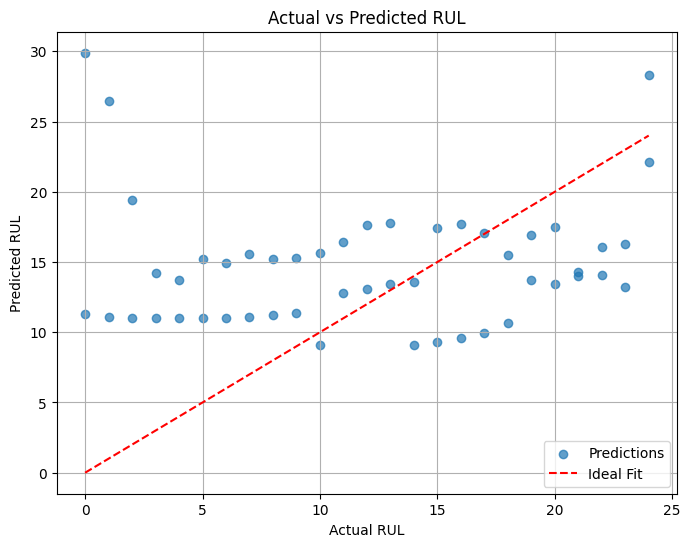

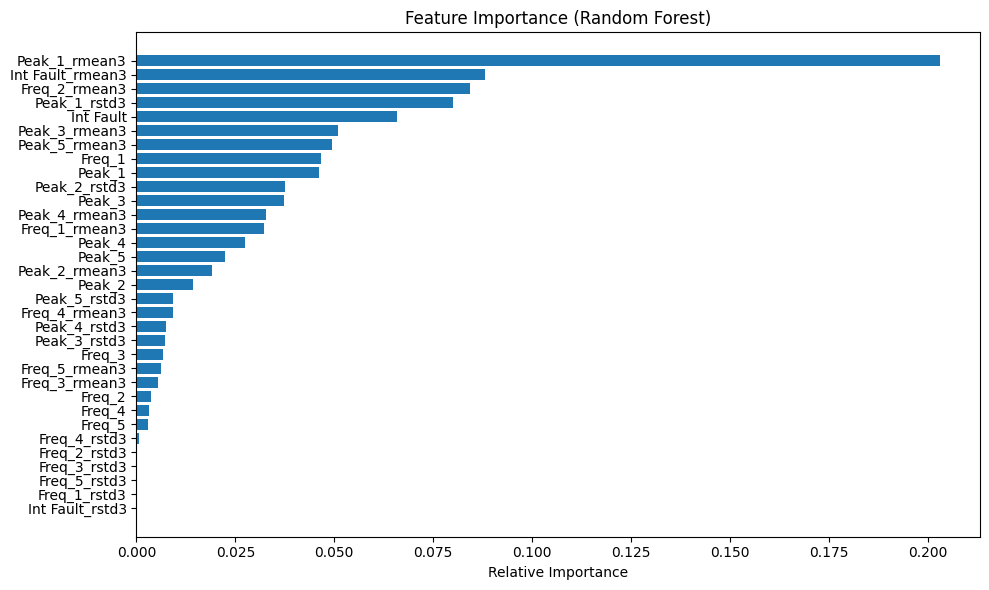

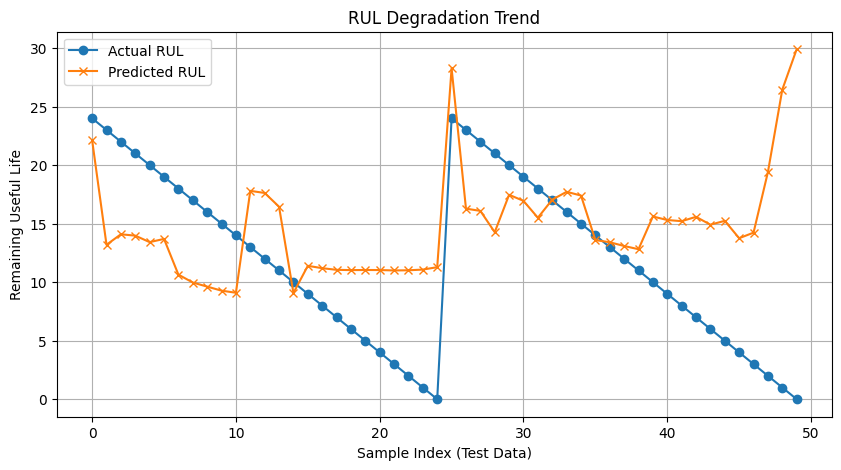

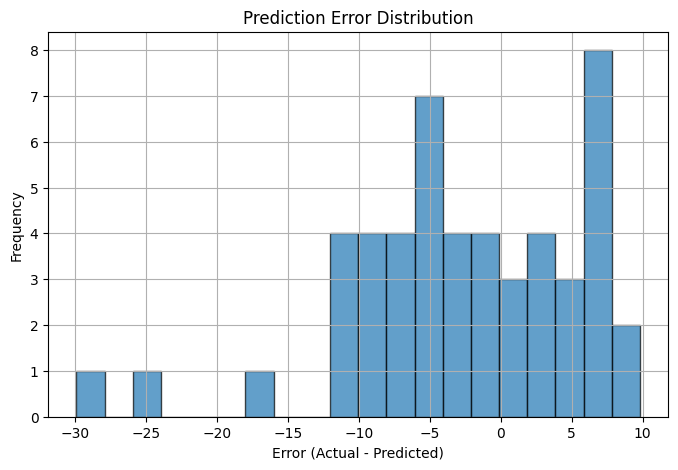

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# === 1️⃣  Actual vs Predicted RUL ===
y_pred = rf.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

# === 2️⃣  Feature Importance ===
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [final_features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(features_sorted[::-1], importances[indices][::-1])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# === 3️⃣  RUL Degradation Trend (Predicted vs Actual over runs) ===
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Actual RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.title('RUL Degradation Trend')
plt.xlabel('Sample Index (Test Data)')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.show()

# === 4️⃣  Error Distribution ===
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
import numpy as np
import pandas as pd
import joblib
import json
from scipy.fft import fft


class FluidSimulator:
    def __init__(self, model_path, scaler_path, features_path, fs=10, duration=600):
        self.fs = fs
        self.duration = duration
        self.time = np.arange(duration) / fs
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

        with open(features_path, 'r') as f:
            self.requiredVars = json.load(f)

    def simulate_base_signals(self):
        """Default (normal) flow and pressure without faults."""
        flow = 1.2 + 0.02 * np.random.randn(self.duration)
        pressure = 1.18 + 0.02 * np.random.randn(self.duration)
        return flow, pressure

    def inject_faults(self, flow, pressure):
        """Override for specific fluid fault logic."""
        return flow, pressure

    def extract_features(self, flow, pressure):
        """Simulate frequencies and peaks similar to pump vibration data."""
        feats = {}
        for i in range(1, 6):
            segment = flow[self.duration//6 * (i-1):self.duration//6 * i]
            freq = np.mean(np.abs(fft(segment))) / len(segment)
            peak = np.max(segment) - np.min(segment)
            feats[f"Freq_{i}"] = freq
            feats[f"Peak_{i}"] = peak

        feats["Int Fault"] = 1  # assume one active fault
        feat_array = [feats[var] for var in self.requiredVars]
        df = pd.DataFrame([feat_array], columns=self.requiredVars)

        # Scale the features
        df_scaled = pd.DataFrame(self.scaler.transform(df), columns=self.requiredVars)
        return df_scaled, feats

    def predict_rul(self, features_scaled):
        """Predict Remaining Useful Life using trained regression model."""
        predicted_rul = self.model.predict(features_scaled)[0]
        return predicted_rul

    def run(self):
        """Complete pipeline: simulate → inject → extract → predict."""
        flow, pressure = self.simulate_base_signals()
        flow, pressure = self.inject_faults(flow, pressure)
        features_scaled, raw_feats = self.extract_features(flow, pressure)
        rul = self.predict_rul(features_scaled)
        return {"predicted_RUL": rul, "features_used": raw_feats}


# -------------------------
# Custom Pump Fault Simulation
# -------------------------
class WaterSimulator(FluidSimulator):
    def inject_faults(self, flow, pressure):
        fault_range = range(100, 200)
        idx = np.array(list(fault_range))
        t = self.time[idx] - self.time[idx[0]]
        flow[idx] += 0.5*np.sin(2*np.pi*0.3*t) - 0.4
        pressure[idx] += 0.6*np.sin(2*np.pi*1.2*t)
        return flow, pressure


# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    sim = WaterSimulator(
        model_path="rul_model.pkl",
        scaler_path="scaler.pkl",
        features_path="features_list.json",
        fs=10,
        duration=600
    )

    results = sim.run()
    print("\n Predicted Remaining Useful Life (RUL):", results["predicted_RUL"])
    print("\n Extracted Feature Summary:")
    for k, v in results["features_used"].items():
        print(f"  {k}: {v:.4f}")



 Predicted Remaining Useful Life (RUL): 3.9633333333333334

 Extracted Feature Summary:
  Freq_1: 0.0137
  Peak_1: 0.0904
  Freq_2: 0.0149
  Peak_2: 1.0379
  Freq_3: 0.0139
  Peak_3: 0.1113
  Freq_4: 0.0136
  Peak_4: 0.0894
  Freq_5: 0.0137
  Peak_5: 0.0924
  Int Fault: 1.0000
